## Bayesian parameter estimation using MCMC

Authors: Audrey Olivier and Dimitris Giovanis <br>
Last modified on 12/14/2018 by Audrey Olivier

In Bayesian parameter estimation, one is looking to estimate the posterior pdf of the parameter vector characterizing the model, based on available data. The posterior pdf is given by Bayes' theorem:

$$ p(\theta \vert data) = \frac{p(data \vert \theta) p(\theta)}{p(data)} $$

The posterior pdf of nonlinear non-Gaussian models is often intractable, approximations must be used. In particular, Markov Chain Monte Carlo methods are a very popular way to sample from the posterior pdf. This notebook illustrates how to perfrom Bayesian parameter estimation via MCMC in UQpy, using the BayesParameterEstimation class. At the end of this notebook, we also show how to quickly check your results using some simple Diagnostics tools implemented in UQpy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots

In [2]:
def pdf_from_kde(domain, samples1d):
    bandwidth = 1.06 * np.std(samples1d) * samples1d.size ** (-1/5)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples1d.reshape((-1,1)))
    log_dens = kde.score_samples(domain)
    return np.exp(log_dens)

## Probability model

Generate data from a probability model, here a Gaussian pdf, then learn its parameters, mean and covariance, from this data.

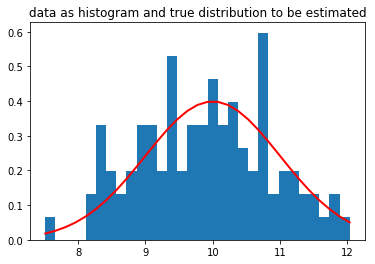

In [3]:
np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 100).reshape((-1, 1))
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In a Bayesian setting, the definition of a prior pdf is a key point. The prior for the parameters must be defined in the model. Note that if no prior is given, an inproper, uninformative, prior is chosen, $p(\theta)=1$ for all $\theta$.

In [4]:
# create an instance of class Model
candidate_model = InferenceModel(distribution_object=Distribution('normal'), nparams=2, 
                                 prior=Distribution(['uniform','lognormal'],params=[[0, 15], [1, 0, 1]]))

In [5]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data_1, inference_model=candidate_model, sampling_method='MCMC', 
                                           nsamples=500, algorithm='MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

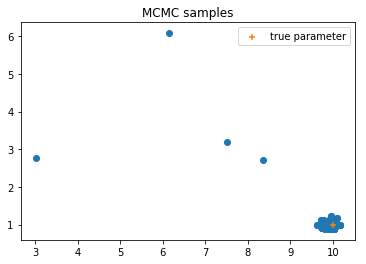

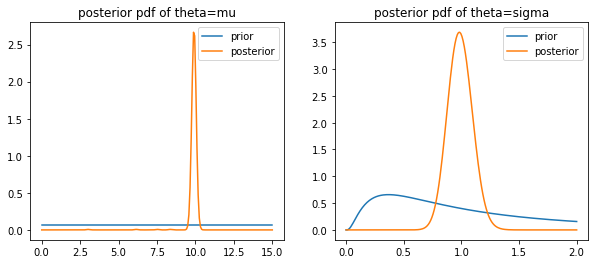

In [6]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
pdf = pdf_from_kde(domain, s[:, 0])
ax[0].plot(domain, Distribution('uniform').pdf(domain, [0,15]), label='prior')
ax[0].plot(domain, pdf, label='posterior')
ax[0].set_title('posterior pdf of theta=mu')
ax[0].legend()

domain = np.linspace(0, 2, 200)[:, np.newaxis]
pdf = pdf_from_kde(domain, s[:, 1])
ax[1].plot(domain, Distribution('lognormal').pdf(domain, [1,0,1]), label='prior')
ax[1].plot(domain, pdf, label='posterior')
ax[1].set_title('posterior pdf of theta=sigma')
ax[1].legend()

plt.show()

## Regression model - $y=X \theta + \epsilon$

In [7]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

h = RunModel(model_script='pfn_models.py', model_object_name = 'model_quadratic', var_names = ['theta_0', 'theta_1'])
h.run(samples=param_true)
data = h.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print('Shape of data: {}'.format(data.shape))

Shape of data: (50,)


In [8]:
inference_model = InferenceModel(nparams=2, run_model_object=h, error_covariance=error_covariance)

In [9]:
bayes_estimator = BayesParameterEstimation(data=data, inference_model=inference_model, sampling_method='MCMC', 
                                           nsamples=500, algorithm='MH', jump=10, nburn=0, 
                                           proposal=Distribution(['normal', 'normal'], params=[[0., 0.1], [0., 0.05]]),
                                           seed=[0.5, 2.5])

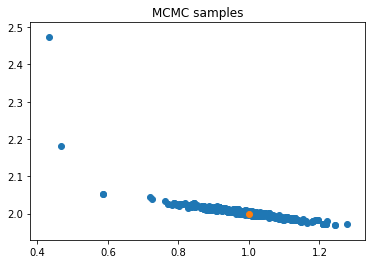

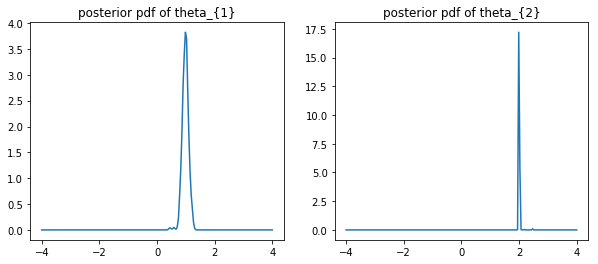

In [10]:
s = bayes_estimator.samples
plt.scatter(s[:,0], s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s[:, 0])
ax[0].plot(domain, pdf_, label='posterior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s[:, 1])
ax[1].plot(domain, pdf_, label='posterior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

In [11]:
from UQpy.Utilities import MCMC_diagnostics
MCMC_diagnostics(sampling_outputs = bayes_estimator.sampler)

Diagnostics for a single chain of MCMC 

!!! Warning !!! These diagnostics are purely qualitative and should be used with caution 

Acceptance ratio of the chain(s) = 0.06779999999999996. 

Univariate Effective Sample Size in each dimension:
Dimension 1: ESS = 1940.9910077836278, minimum ESS recommended = 6146.334113110603
Dimension 2: ESS = 3353.4973397616927, minimum ESS recommended = 6146.334113110603


Looking at the chains above, it appears that a better proposal should be chosen for that problem in order to get better mixing properties of the chain. This can also be seen through the small value of the acceptance ratio (it is often recommended to choose the proposal in order to obtain an acceptance ratio between 20-40%). Finally, it seems that estimation of the first parameter would require more fine tuning, as convergence is not yet achieved, and the ESS is small compared to the recommended minESS. One should thus probably run the chains for a longer time to obtain satisfactory estimates of the parameters and their posterior pdfs.